**Welcome to pyLIMA (v2) tutorial 2!**

This second tutorial will give you some basics about how to reconfigure your input parameters.

If you do not like the standard pyLIMA parameters, this is made for you.

We are going to fit the same light curves as in tutorial 1, but using different parametrization.

In [3]:
### First import the required libraries as before.
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
import os, sys

from pyLIMA import event
from pyLIMA import telescopes
from pyLIMA import microlmodels

In [4]:
### Create a new EVENT object and give it a name.
your_event = event.Event()
your_event.name = 'My event name'

You now need to associate some data sets with this **EVENT**. 

For this example, you will use simulated I-band data sets from two telescopes, OGLE and LCO.

The data sets are pre-formatted: column 1 is the date, column 2 the magnitude and column 3 the uncertainty in the magnitude.

In [5]:
### Load up the data
data_1 = np.loadtxt('./Survey_1.dat')
telescope_1 = telescopes.Telescope(name = 'OGLE', 
                                   camera_filter = 'I',
                                   light_curve = data_1.astype(float),
                                   light_curve_names = ['time','mag','err_mag'],
                                   light_curve_units = ['JD','mag','mag'])

data_2 = np.loadtxt('./Followup_1.dat')
telescope_2 = telescopes.Telescope(name = 'LCO', 
                                   camera_filter = 'I',
                                   light_curve = data_2.astype(float),
                                   light_curve_names = ['time','mag','err_mag'],
                                   light_curve_units = ['JD','mag','mag'])

In [6]:
### Append these two telescope data sets to your EVENT object.
your_event.telescopes.append(telescope_1)
your_event.telescopes.append(telescope_2)

In [7]:
### Define the survey telescope that you want to use to align all other data sets to.
### We recommend using the data set with the most measurements covering the gretest 
### time span of observations:
your_event.find_survey('OGLE')

In [8]:
### Run a quick sanity check on your input.
your_event.check_event()

check_event  : Everything looks fine...


Set the microlensing limb-darkening coefficients (gamma) for each telescope:

In [9]:
your_event.telescopes[0].gamma = 0.5
your_event.telescopes[1].gamma = 0.5

Fit an FSPL model to the data using the Trust Region Reflective (TRF) algorithm:

We can make this faster by using the results from tutorial 1.

In [10]:
guess_parameters = [79.9, 0.008, 10.1, 0.023]

Define the model and fit method (as in tutorial 1):

In [11]:
from pyLIMA.models import FSPL_model
fspl = FSPL_model.FSPLmodel(your_event)

Import the TRF fitting algorithm and fit:

In [12]:
from pyLIMA.fits import TRF_fit
my_fit = TRF_fit.TRFfit(fspl)
my_fit.model_parameters_guess = guess_parameters
my_fit.fit()

initial_guess  : Initial parameters guess SUCCESS
Using guess:  [79.9, 0.008, 10.1, 0.023, 3213.986935573641, -172.21538636107846, 96637.9563454496, 119851.27931342222]
fit  : Trust Region Reflective fit SUCCESS
best_model: [79.93092285412126, 0.008144777859401648, 10.110744577682075, 0.02259885484752916, 2917.6489496575373, 208.24259756591277, 92640.70959168556, 49186.51175486384]  chi2: 3851.055779868046


Let's see the plot. Zoom close to the peak again to see what is going on.

/home/Tux/ytsapras/Installed_Programs/anaconda3/envs/pylima2/lib/python3.9/site-packages/pyLIMA-0.8.3-py3.9.egg/pyLIMA/telescopes.py:237: RuntimeWarning: divide by zero encountered in divide
  inv_err_flux = 1.0/err_flux
/home/Tux/ytsapras/Installed_Programs/anaconda3/envs/pylima2/lib/python3.9/site-packages/pyLIMA-0.8.3-py3.9.egg/pyLIMA/toolbox/plots.py:21: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  figure_axe.errorbar(time, mag, mag_error, fmt='.', color=color, marker=marker, label=name)


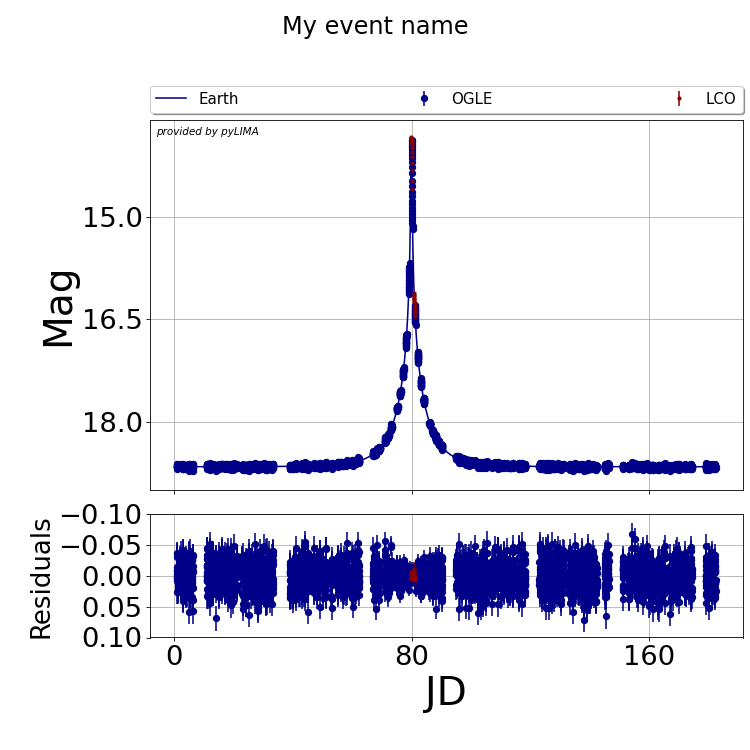

In [13]:
from pyLIMA.outputs import pyLIMA_plots
pyLIMA_plots.plot_lightcurves(fspl, my_fit.fit_results['best_model'])
plt.show()

All right, looks fine, as before. 

Now let's say you dislike the rho parameter and you want to change it to use log(rho) instead.

Let's see how to do this.

We need to specify within pyLIMA how the new parameter depends on the old parameter.

In essence, we need to define a transformation function within pyLIMA.

For this particular transformation, i.e. from rho to log(rho), pyLIMA already provides the necessary functions to convert back and forth: 

In [14]:
from pyLIMA.fits import fancy_parameters
fancy_parameters.fancy_parameters_dictionnary = {'log_rho':'rho'}

To see all available default options within pyLIMA, please look at the fancy_parameters module or type dir(fancy_parameters) in the Python prompt.

Now we need to perform a new fit with the newly defined parameters.

Use the same guess parameters as before but this time the last parameter needs to be log(rho), as we previously defined it:

In [15]:
guess_parameters2 = [79.9, 0.008, 10.1, np.log10(0.023)]

We need to tell the fit to use fancy_parameters, otherwise it will use the defaults.

In [16]:
my_fit2 = TRF_fit.TRFfit(fspl, fancy_parameters=True)
my_fit2.model_parameters_guess = guess_parameters2
my_fit2.fit()

initial_guess  : Initial parameters guess SUCCESS
Using guess:  [79.9, 0.008, 10.1, -1.6382721639824072, 3213.986935573641, -172.21538636107846, 96637.9563454496, 119851.27931342222]
fit  : Trust Region Reflective fit SUCCESS
best_model: [79.93092282872622, 0.008144770918164485, 10.110744853788114, -1.6459135590049554, 2917.6488292956774, 208.24271604083745, 92640.70182079397, 49186.58492407255]  chi2: 3851.0557798643663


So this works great! 

OK, try something more complicated now: define t_star = rho*tE and log_rho = log(rho).

log_rho is already provided by pyLIMA, but t_star isn't. 

So we need to tell pyLIMA what kind of change we want:

In [17]:
def t_star(x):
    return x.rho*x.tE

setattr(fancy_parameters, 't_star', t_star)

def tE(x):
    return x.t_star/10**(x.log_rho)

setattr(fancy_parameters, 'tE', tE)


Update the parameter dictionary with the new definitions

In [18]:
fancy_parameters.fancy_parameters_dictionnary = {'log_rho':'rho', 't_star':'tE'}

 t_star = rho * tE so in our example that is 10.1 * 0.023 (see guess_parameters2 above):

In [19]:
guess_parameters3 = [79.9, 0.008, 10.1 * 0.023, np.log10(0.023)]

Do the fit using the new parameter definitions:

In [20]:
my_fit3 = TRF_fit.TRFfit(fspl, fancy_parameters=True)
my_fit3.model_parameters_guess = guess_parameters3
my_fit3.fit()

initial_guess  : Initial parameters guess SUCCESS
Using guess:  [79.9, 0.008, 0.23229999999999998, -1.6382721639824072, 3213.986935573641, -172.21538636107846, 96637.9563454496, 119851.27931342222]
fit  : Trust Region Reflective fit SUCCESS
best_model: [79.93092282061683, 0.00814476942502558, 0.22849126448092136, -1.6459135478842293, 2917.6488451609316, 208.24270069273697, 92640.70231834744, 49186.589483567426]  chi2: 3851.055779863628


Let's look at the optimized parameters and the $\chi^2$ of the fit:

In [21]:
my_fit3.fit_results['best_model']
my_fit3.fit_results['chi2']

3851.055779863628

If you have forgotten the order of the parameters, do:

In [22]:
my_fit3.fit_parameters.keys()

odict_keys(['t0', 'u0', 't_star', 'log_rho', 'fsource_OGLE', 'fblend_OGLE', 'fsource_LCO', 'fblend_LCO'])

Note that the results now are displayed with our newly defined parameters.

This concludes tutorial 2.